* In this activity, you will study feature importance using the XGBoost library
* After building your XGBoost model (classifier or regressor) studying feature importance is just one line of code

In [1]:
# Import modules
from google.colab import files
import matplotlib.pyplot as plt
from functools import *
import re  # For removing letter in string 
import operator  # For sorting dictionary
import seaborn as sns
import pandas as pd
import numpy as np
np.set_printoptions(formatter = {'float': '{: 0.1f}'.format})

import xgboost as xgb
from xgboost import plot_importance
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, mean_absolute_error

%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


TensorFlow 1.x selected.


# **Import and Setup**

In [2]:
uploaded = files.upload()
file_name = "heart.csv"

Saving heart.csv to heart.csv


In [3]:
dataset = pd.read_csv(file_name, delimiter=',')
print(dataset.shape)
dataset.head()

(303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [0]:
# Shuffle the dataset
# NOTE: shuffle dataframe in-place and reset the index
dataset = dataset.sample(frac=1).reset_index(drop=True)

# Convert Pandas Dataframe to Numpy dArray
dataset_np = dataset.values

In [0]:
# Model Evaluation
def model_evaluation_classification(xvalid, yvalid, model):
    prediction = model.predict(xvalid)
    accuracy = accuracy_score(yvalid, prediction.round()) * 100.0
    precision = precision_score(yvalid, prediction.round(), average='micro') * 100.0
    recall = recall_score(yvalid, prediction.round(), average='micro') * 100.0
    f1score = f1_score(yvalid, prediction.round(), average='micro')

    print("Accuracy: %.2f%%" % (accuracy))
    print("Precision: %.2f%%" % (precision))
    print("Recall: %.2f%%" % (recall))
    print("F1-score: %.2f\n" % (f1score))

def model_evaluation_regression(xvalid, yvalid, model):
    prediction = model.predict(xvalid)
    mae = mean_absolute_error(yvalid, prediction)
    print("MAE: %.2f\n" % (mae))

# **Binary Classification using XGBClassifier()**

Task #1


In [0]:
X = dataset.drop('sex', axis='columns').values
Y = dataset['sex'].values

In [0]:
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 123)

In [8]:
# Following are some important parameters: n_estimators=100, max_depth=3
xg_cla = xgb.XGBClassifier(n_estimators=30, max_depth=3)
xg_cla.fit(xtr, ytr, eval_set=[(xva, yva)], verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

### Evaluate on the training set itself

In [0]:
preds = xg_cla.predict(xtr)

In [10]:
print(ytr[:10])
print(preds[:10])

[1 1 0 1 0 1 1 1 1 0]
[1 1 0 1 0 1 1 1 1 0]


### Evaluate on the validation set

In [0]:
preds = xg_cla.predict(xva)

In [12]:
print(yva[:10])
print(preds[:10])

[1 1 1 1 0 1 0 0 1 0]
[1 1 1 1 1 1 0 0 0 1]


### Evaluation based on precision, accuracy, and recall

In [13]:
model_evaluation_classification(xva, yva, xg_cla)

Accuracy: 68.85%
Precision: 68.85%
Recall: 68.85%
F1-score: 0.69



### Visualize one of the trees

In [0]:
plt.rcParams['figure.figsize'] = [50, 10]

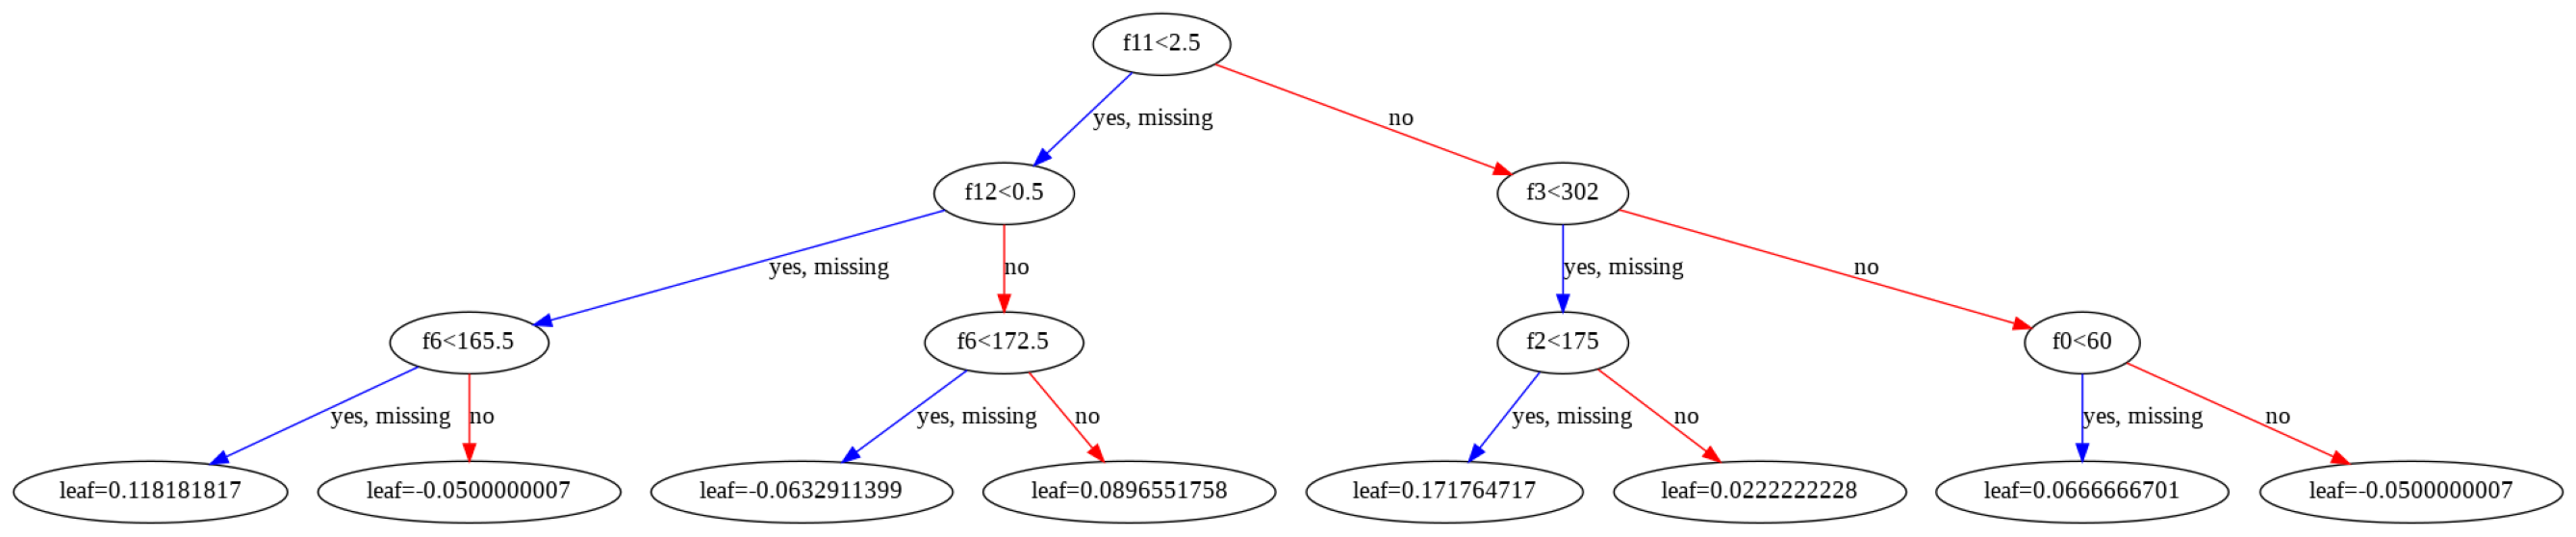

In [15]:
xgb.plot_tree(xg_cla, num_trees=0)

### Visualize a tree with appropriate feature names

In [16]:
f = open(file_name, encoding='utf-8-sig')
line = f.readline()
f.close()
cols = line.strip().split(',')
print(cols)

del cols[1] # Remove the output column (sex)
f = open('fmap1.txt', 'w')
for i, col in enumerate(cols):
    f.write(str(i) + '\t' + str(col) + '\tq\n')
f.close()

! cat fmap1.txt

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
0	age	q
1	cp	q
2	trestbps	q
3	chol	q
4	fbs	q
5	restecg	q
6	thalach	q
7	exang	q
8	oldpeak	q
9	slope	q
10	ca	q
11	thal	q
12	target	q


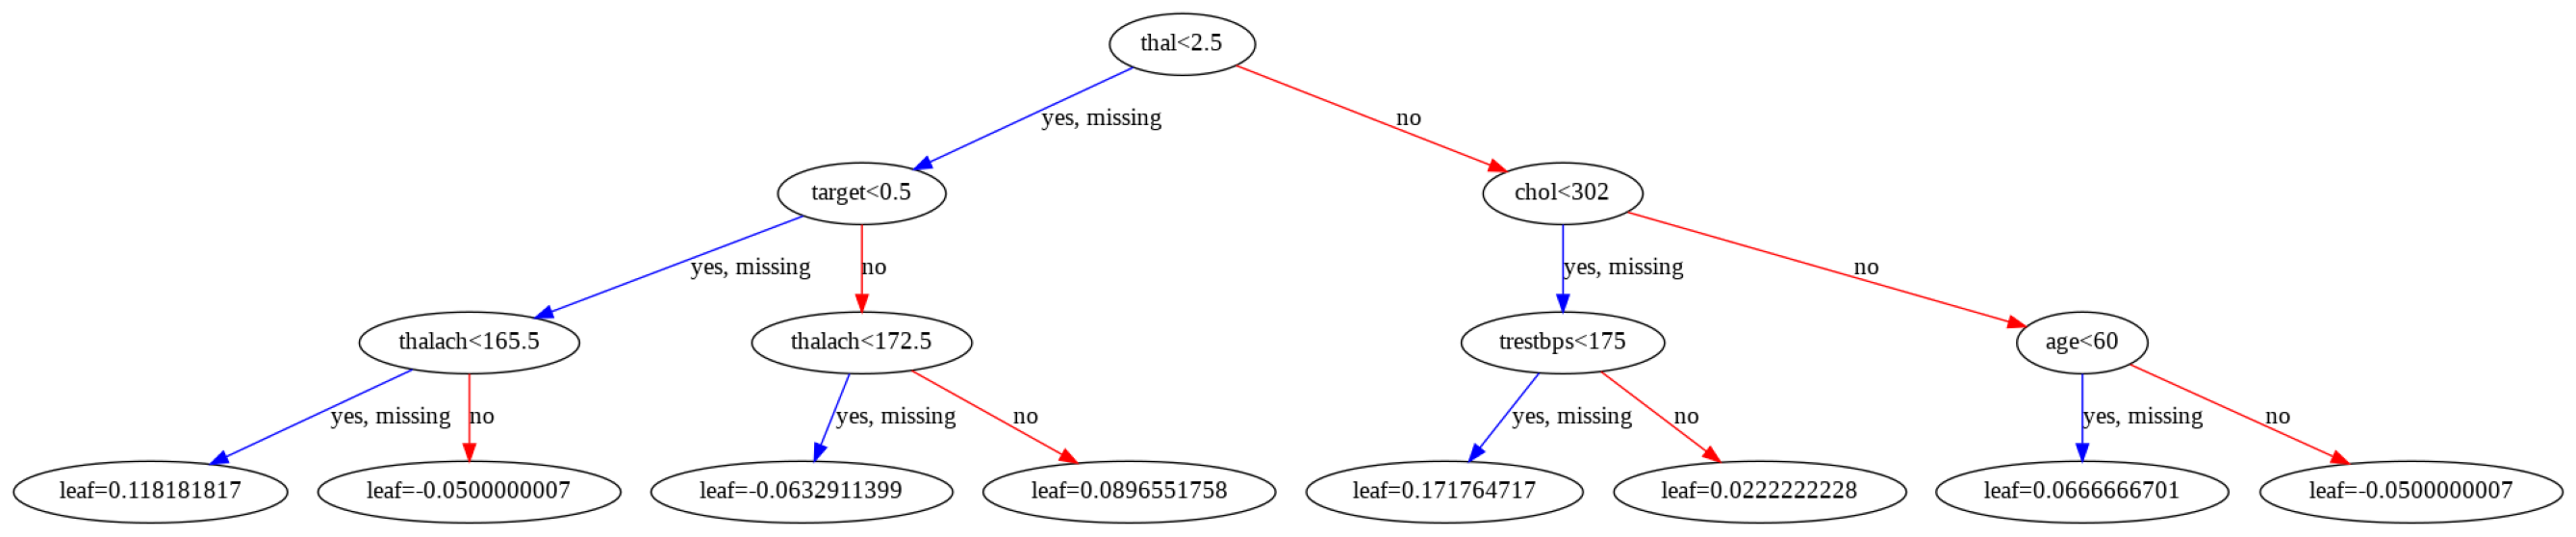

In [17]:
xgb.plot_tree(xg_cla, num_trees=0, fmap='fmap1.txt')

**Comment:** if thalach is more than 2.5 and less than 176, and age is less than 38, then the gender is less likely a male.

### Feature Importance 

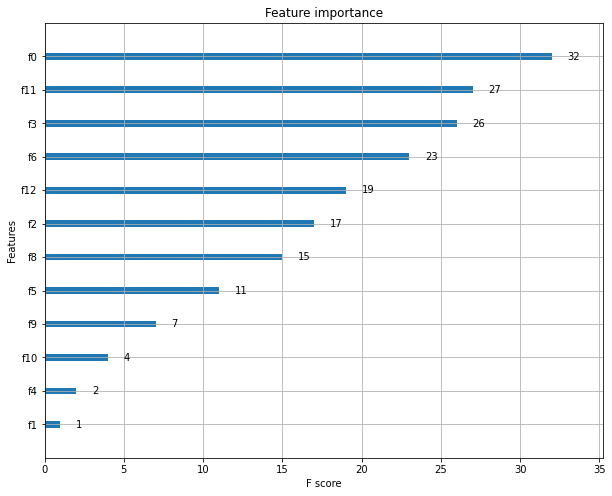

In [18]:
plt.rcParams['figure.figsize'] = [10, 8]
plot_importance(xg_cla)

# **Regression using XGBRegressor()**

Task #1


In [0]:
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values

In [0]:
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 456)

In [21]:
# Following are some important parameters: n_estimators=100, max_depth=3
xg_reg = xgb.XGBRegressor(n_estimators=30, max_depth=3, objective='reg:squarederror')
xg_reg.fit(xtr, ytr, eval_set=[(xva, yva)], verbose=0)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=30,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

### Evaluate on the training set itself

In [0]:
preds = xg_reg.predict(xtr)

In [23]:
print(ytr[:10])
print(preds[:10])

[57 41 47 65 61 58 62 67 56 46]
[ 56.2  46.4  54.9  50.2  56.8  52.3  57.3  58.0  56.7  49.6]


### Evaluate on the validation set

In [0]:
preds = xg_reg.predict(xva)

In [25]:
print(yva[:10])
print(preds[:10])

[65 51 54 44 45 41 42 64 41 44]
[ 56.0  57.6  47.8  55.8  44.0  48.7  42.3  52.1  49.6  44.6]


### Evaluation based on MAE

In [26]:
model_evaluation_regression(xva, yva, xg_reg)

MAE: 6.33



### Visualize one of the trees

In [0]:
plt.rcParams['figure.figsize'] = [50, 10]

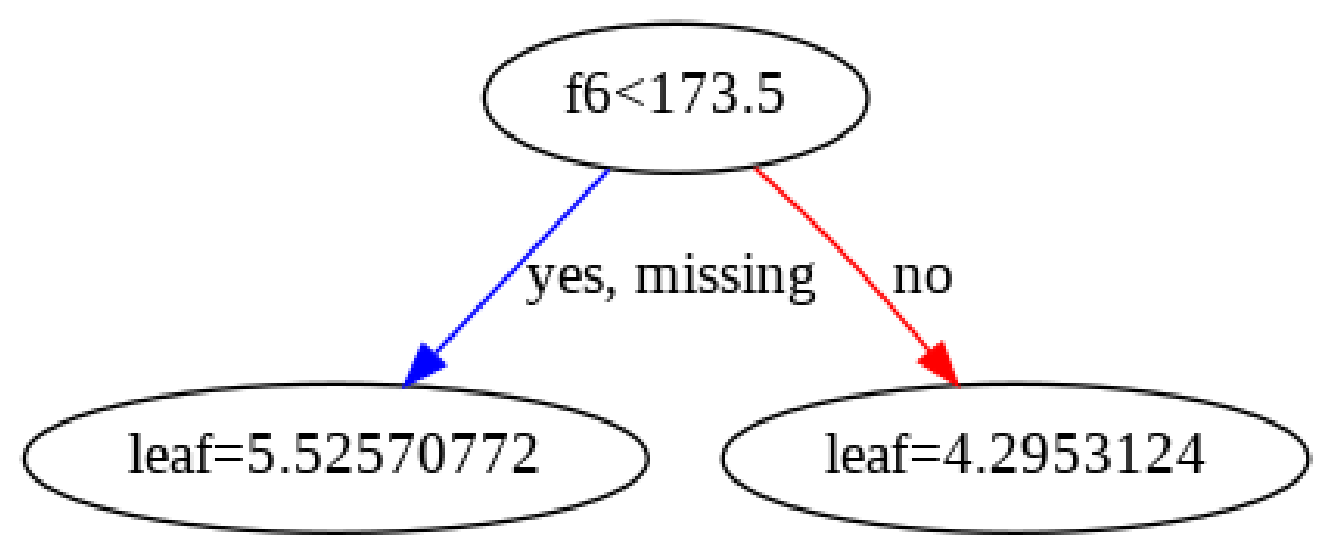

In [28]:
xgb.plot_tree(xg_reg, num_trees=0)

### Visualize a tree with appropriate feature names

In [29]:
f = open(file_name, encoding='utf-8-sig')
line = f.readline()
f.close()
cols = line.strip().split(',')
print(cols)

del cols[0] # Remove the output column (age)
f = open('fmap2.txt', 'w')
for i, col in enumerate(cols):
    f.write(str(i) + '\t' + str(col) + '\tq\n')
f.close()

! cat fmap2.txt

['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']
0	sex	q
1	cp	q
2	trestbps	q
3	chol	q
4	fbs	q
5	restecg	q
6	thalach	q
7	exang	q
8	oldpeak	q
9	slope	q
10	ca	q
11	thal	q
12	target	q


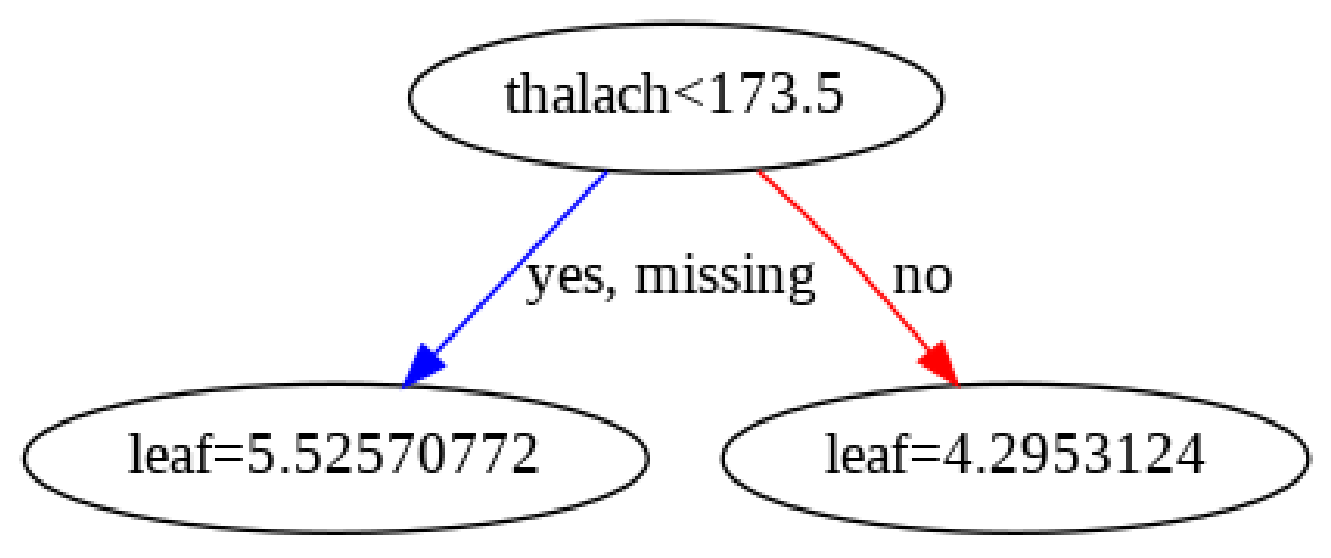

In [30]:
xgb.plot_tree(xg_reg, num_trees=0, fmap='fmap2.txt')

### Feature Importance 

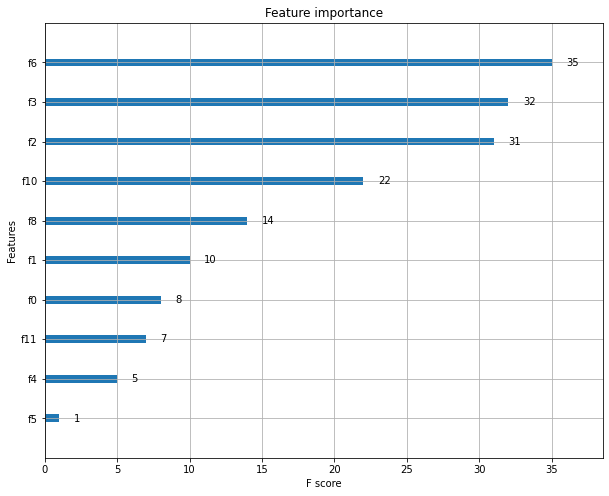

In [31]:
plt.rcParams['figure.figsize'] = [10, 8]
plot_importance(xg_reg)

# **NN Model (Binary Classification)**

In [0]:
X = dataset.drop('sex', axis='columns').values
Y = dataset['sex'].values
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 789)

In [33]:
callback_a = ModelCheckpoint(filepath = "classification.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

model_classification = Sequential()
model_classification.add(Dense(13, input_dim=len(xtr[0, :]), activation='relu'))
model_classification.add(Dense(7, activation='relu'))
model_classification.add(Dense(1, activation='sigmoid'))

model_classification.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
history_classification = model_classification.fit(xtr, ytr, validation_data=(xva, yva), epochs=1024, batch_size=100, callbacks = [callback_a, callback_b], verbose=0)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


### Evaluation based on precision, accuracy, and recall

In [34]:
model_evaluation_classification(xva, yva, model_classification)

Accuracy: 65.57%
Precision: 65.57%
Recall: 65.57%
F1-score: 0.66



**Comment:** Interesting! XGB is better than NN model!

# **NN Model (Regression)**

In [0]:
X = dataset.drop('age', axis='columns').values
Y = dataset['age'].values
xtr, xva, ytr, yva = train_test_split(X, Y, test_size = 0.2, random_state = 777)

In [0]:
callback_a = ModelCheckpoint(filepath = "regression.hdf5", monitor='val_loss', save_best_only = True, save_weights_only = True, verbose = 0)
callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

model_regression = Sequential()
model_regression.add(Dense(13, input_dim=len(xtr[0, :]), activation='relu'))
model_regression.add(Dense(7, activation='relu'))
model_regression.add(Dense(1, activation='linear'))

model_regression.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
history_regression = model_regression.fit(xtr, ytr, validation_data=(xva, yva), epochs=1024, batch_size=100, callbacks = [callback_a, callback_b], verbose=0)

In [37]:
model_evaluation_regression(xva, yva, model_regression)

MAE: 6.89



**Comment:** XGB is better than NN regression model

# **Feature importance and removal using XGBoost**

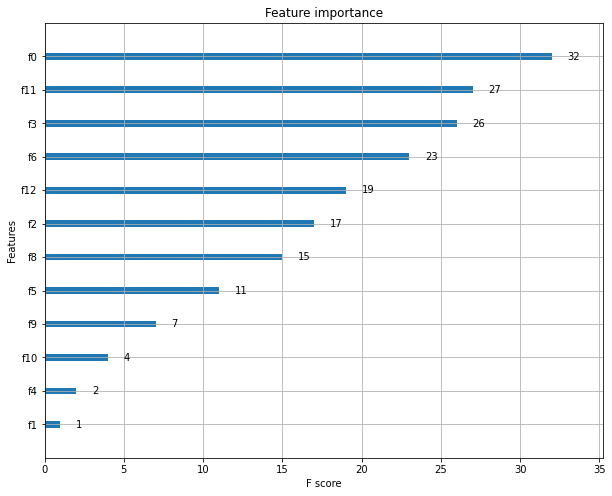

In [38]:
plt.rcParams['figure.figsize'] = [10, 8]
plot_importance(xg_cla)

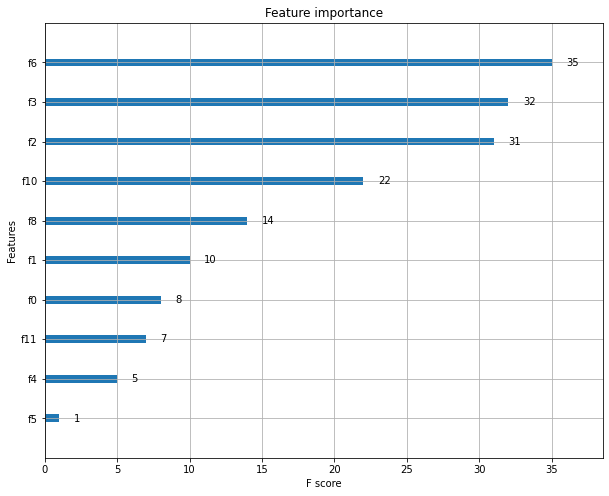

In [39]:
plt.rcParams['figure.figsize'] = [10, 8]
plot_importance(xg_reg)

### Binary Classification

In [40]:
# age(0) | sex(1) | cp(2) | trestbps(3) | chol(4) |fbs(5) | restecg(6) | thalach(7) | exang(8) | oldpeak(9) | slope(10)
# ca(11) | thal(12) | target(13)
classification_features = []
for item in sorted(xg_cla.get_booster().get_score(fmap="fmap1.txt"), key=xg_cla.get_booster().get_score(fmap="fmap1.txt").get, reverse=0):
    # index = int(re.sub('[a-zA-Z]', '', str(item))) + 1
    # index = 0 if index == 1 else index  # result = x if a > b else y (skip sex(1))
    # classification_features.append(dataset.columns[index])
    classification_features.append(item)

xgb_classification_acc_score = []
classification_features_checked = ["sex"]
for item in classification_features:
    classification_features_checked.append(str(item))
    x = dataset.drop(classification_features_checked, axis='columns').values
    y = dataset['sex'].values

    # Train
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size = 0.2, random_state = 111)
    xgb_classification = xgb.XGBClassifier(n_estimators=30, max_depth=3)
    xgb_classification.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=0)

    # Evaluation
    print(classification_features_checked)
    print(x.shape)
    model_evaluation_classification(xvalid, yvalid, xgb_classification)

    # Store Accuracy
    prediction = xgb_classification.predict(xvalid)
    xgb_classification_acc_score.append(f1_score(yvalid, prediction.round(), average='micro'))

['sex', 'cp']
(303, 12)
Accuracy: 65.57%
Precision: 65.57%
Recall: 65.57%
F1-score: 0.66

['sex', 'cp', 'fbs']
(303, 11)
Accuracy: 65.57%
Precision: 65.57%
Recall: 65.57%
F1-score: 0.66

['sex', 'cp', 'fbs', 'ca']
(303, 10)
Accuracy: 65.57%
Precision: 65.57%
Recall: 65.57%
F1-score: 0.66

['sex', 'cp', 'fbs', 'ca', 'slope']
(303, 9)
Accuracy: 65.57%
Precision: 65.57%
Recall: 65.57%
F1-score: 0.66

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg']
(303, 8)
Accuracy: 67.21%
Precision: 67.21%
Recall: 67.21%
F1-score: 0.67

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg', 'oldpeak']
(303, 7)
Accuracy: 67.21%
Precision: 67.21%
Recall: 67.21%
F1-score: 0.67

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg', 'oldpeak', 'trestbps']
(303, 6)
Accuracy: 70.49%
Precision: 70.49%
Recall: 70.49%
F1-score: 0.70

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg', 'oldpeak', 'trestbps', 'target']
(303, 5)
Accuracy: 70.49%
Precision: 70.49%
Recall: 70.49%
F1-score: 0.70

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg

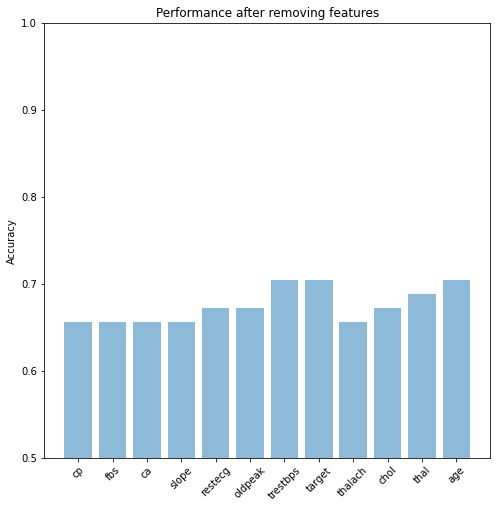

In [41]:
y_pos = np.arange(len(classification_features))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, xgb_classification_acc_score, align='center', alpha=0.5)
plt.xticks(y_pos, classification_features, fontsize=10, rotation=45)
plt.ylim(0.5, 1.0)
plt.ylabel('Accuracy')
plt.title('Performance after removing features')

plt.show()

### Regression

In [42]:
# age(0) | sex(1) | cp(2) | trestbps(3) | chol(4) |fbs(5) | restecg(6) | thalach(7) | exang(8) | oldpeak(9) | slope(10)
# ca(11) | thal(12) | target(13)
regression_features = []
for item in sorted(xg_reg.get_booster().get_score(fmap="fmap2.txt"), key=xg_reg.get_booster().get_score(fmap="fmap2.txt").get, reverse=0):
    regression_features.append(item)

xgb_regression_acc_score = []
regression_features_checked = ["age"]
for item in regression_features:
    regression_features_checked.append(str(item))
    x = dataset.drop(regression_features_checked, axis='columns').values
    y = dataset['age'].values

    # Train
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size = 0.2, random_state = 111)
    xgb_regression = xgb.XGBRegressor(n_estimators=30, max_depth=3, objective='reg:squarederror')
    xgb_regression.fit(xtrain, ytrain, eval_set=[(xvalid, yvalid)], verbose=0)

    # Evaluation
    print(regression_features_checked)
    print(x.shape)
    model_evaluation_regression(xvalid, yvalid, xgb_regression)

    # Store Accuracy
    prediction = xgb_regression.predict(xvalid)
    xgb_regression_acc_score.append(mean_absolute_error(yvalid, prediction.round()))

['age', 'restecg']
(303, 12)
MAE: 7.12

['age', 'restecg', 'fbs']
(303, 11)
MAE: 7.09

['age', 'restecg', 'fbs', 'thal']
(303, 10)
MAE: 7.14

['age', 'restecg', 'fbs', 'thal', 'sex']
(303, 9)
MAE: 7.15

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp']
(303, 8)
MAE: 7.11

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak']
(303, 7)
MAE: 7.17

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca']
(303, 6)
MAE: 7.75

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca', 'trestbps']
(303, 5)
MAE: 8.00

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca', 'trestbps', 'chol']
(303, 4)
MAE: 8.14

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca', 'trestbps', 'chol', 'thalach']
(303, 3)
MAE: 8.46



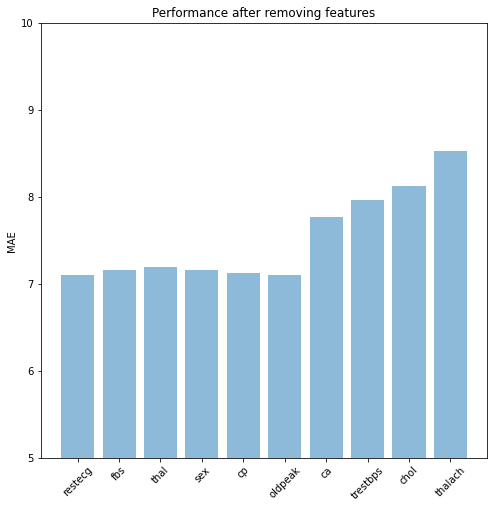

In [43]:
y_pos = np.arange(len(regression_features))

plt.figure(figsize=(8, 8))
plt.bar(y_pos, xgb_regression_acc_score, align='center', alpha=0.5)
plt.xticks(y_pos, regression_features, fontsize=10, rotation=45)
plt.ylim(5, 10)
plt.ylabel('MAE')
plt.title('Performance after removing features')

plt.show()

### NN Model (Binary Classification)

In [44]:
nn_classification_acc_score = []
nn_classification_features_checked = ["sex"]
for item in classification_features:
    nn_classification_features_checked.append(str(item))
    x = dataset.drop(nn_classification_features_checked, axis='columns').values
    y = dataset['sex'].values

    # Train
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size = 0.2, random_state = 111)

    ## Callback
    callback_a = ModelCheckpoint(filepath = "classification_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(12, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    ## Compile Model
    model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)

    # Evaluation
    print(nn_classification_features_checked)
    print(x.shape)
    model_evaluation_classification(xvalid, yvalid, model)

    # Store Accuracy
    prediction = model.predict(xvalid)
    nn_classification_acc_score.append(accuracy_score(yvalid, prediction.round()))

['sex', 'cp']
(303, 12)
Accuracy: 65.57%
Precision: 65.57%
Recall: 65.57%
F1-score: 0.66

['sex', 'cp', 'fbs']
(303, 11)
Accuracy: 29.51%
Precision: 29.51%
Recall: 29.51%
F1-score: 0.30

['sex', 'cp', 'fbs', 'ca']
(303, 10)
Accuracy: 70.49%
Precision: 70.49%
Recall: 70.49%
F1-score: 0.70

['sex', 'cp', 'fbs', 'ca', 'slope']
(303, 9)
Accuracy: 70.49%
Precision: 70.49%
Recall: 70.49%
F1-score: 0.70

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg']
(303, 8)
Accuracy: 70.49%
Precision: 70.49%
Recall: 70.49%
F1-score: 0.70

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg', 'oldpeak']
(303, 7)
Accuracy: 70.49%
Precision: 70.49%
Recall: 70.49%
F1-score: 0.70

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg', 'oldpeak', 'trestbps']
(303, 6)
Accuracy: 73.77%
Precision: 73.77%
Recall: 73.77%
F1-score: 0.74

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg', 'oldpeak', 'trestbps', 'target']
(303, 5)
Accuracy: 73.77%
Precision: 73.77%
Recall: 73.77%
F1-score: 0.74

['sex', 'cp', 'fbs', 'ca', 'slope', 'restecg

### NN Model (Regression)

In [45]:
nn_regression_mae_score = []
nn_regression_features_checked = ["age"]
for item in regression_features:
    nn_regression_features_checked.append(str(item))
    x = dataset.drop(nn_regression_features_checked, axis='columns').values
    y = dataset['age'].values

    # Train
    xtrain, xvalid, ytrain, yvalid = train_test_split(x, y, test_size = 0.2, random_state = 111)

    ## Callback
    callback_a = ModelCheckpoint(filepath = "regression_removal.hdf5", monitor='val_loss', save_best_only=True, save_weights_only=True, verbose=0)
    callback_b = EarlyStopping(monitor='val_loss', mode='min', patience=20, verbose=0)

    ## Model
    model = Sequential()
    model.add(Dense(12, input_dim=len(xtrain[0, :]), activation='relu'))
    model.add(Dense(6, activation='relu'))
    model.add(Dense(1, activation='linear'))

    ## Compile Model
    model.compile(loss='mse', optimizer = 'adam', metrics=['mae'])
    history = model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid), epochs=1024, batch_size=100, callbacks=[callback_a, callback_b], verbose=0)

    # Evaluation
    print(nn_regression_features_checked)
    print(x.shape)
    model_evaluation_regression(xvalid, yvalid, model)

    # Store Accuracy
    prediction = model.predict(xvalid)
    nn_regression_mae_score.append(mean_absolute_error(yvalid, prediction.round()))

['age', 'restecg']
(303, 12)
MAE: 7.95

['age', 'restecg', 'fbs']
(303, 11)
MAE: 7.86

['age', 'restecg', 'fbs', 'thal']
(303, 10)
MAE: 8.35

['age', 'restecg', 'fbs', 'thal', 'sex']
(303, 9)
MAE: 7.86

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp']
(303, 8)
MAE: 7.56

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak']
(303, 7)
MAE: 7.43

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca']
(303, 6)
MAE: 7.71

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca', 'trestbps']
(303, 5)
MAE: 10.72

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca', 'trestbps', 'chol']
(303, 4)
MAE: 12.47

['age', 'restecg', 'fbs', 'thal', 'sex', 'cp', 'oldpeak', 'ca', 'trestbps', 'chol', 'thalach']
(303, 3)
MAE: 7.79

